In [8]:
# ============================================================================
# CHUNK 1: ENVIRONMENT SETUP & THE NEURO-TOPOLOGICAL ENGINE (FIXED)
# ============================================================================

#!pip install -qU "transformers>=4.40.0" "accelerate>=0.29.0" "bitsandbytes>=0.43.0" \ "sentence-transformers==2.7.0" "numpy<2.0.0" networkx matplotlib torch

import torch
import torch.nn.functional as F
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple, Union, Dict
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from sentence_transformers import SentenceTransformer

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# Using the Instruct version is recommended for chat templates,
# but we will manually patch the template for the mlabonne base model.
MODEL_ID = "mlabonne/Meta-Llama-3-8B"

class LlamaBrain:
    def __init__(self):
        print(f"   ...Loading Llama 3 Model ({MODEL_ID})...")
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
        )

        self.tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
        self.tokenizer.pad_token = self.tokenizer.eos_token

        # MANUAL TEMPLATE PATCH: Required for base models like mlabonne/Meta-Llama-3-8B
        if self.tokenizer.chat_template is None:
            self.tokenizer.chat_template = "{% for message in messages %}{{'<|im_start|>' + message['role'] + '\\n' + message['content'] + '<|im_end|>\\n'}}{% endfor %}{% if add_generation_prompt %}{{ '<|im_start|>assistant\\n' }}{% endif %}"

        self.model = AutoModelForCausalLM.from_pretrained(
            MODEL_ID,
            quantization_config=bnb_config,
            device_map="auto"
        )
        self.terminators = [self.tokenizer.eos_token_id]

    def generate_thought(self, prompt, max_new_tokens=128):
        messages = [
            {"role": "system", "content": "You are a pure reasoning engine. Be precise and philosophical."},
            {"role": "user", "content": prompt}
        ]
        input_ids = self.tokenizer.apply_chat_template(
            messages, add_generation_prompt=True, return_tensors="pt"
        ).to(self.model.device)

        with torch.no_grad():
            outputs = self.model.generate(
                input_ids,
                max_new_tokens=max_new_tokens,
                temperature=0.7,
                do_sample=True,
                pad_token_id=self.tokenizer.eos_token_id
            )
        return self.tokenizer.decode(outputs[0][input_ids.shape[-1]:], skip_special_tokens=True).strip()

space = SemanticSpace() # Assume SemanticSpace from previous chunk
brain = LlamaBrain()
print("✅ SYSTEM READY: Llama-3 Base Patched.")

   ...Loading Semantic Topology (all-MiniLM-L6-v2)...
   ...Loading Llama 3 Model (mlabonne/Meta-Llama-3-8B)...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

✅ SYSTEM READY: Llama-3 Base Patched.


In [9]:
# ============================================================================
# CHUNK 2: HIGH-DENSITY SEEDING & THE NEURO-LIFTER
# ============================================================================
import itertools
import random

class Phase8Emulator:
    """
    Reconstructs the output of Phase 8 with HIGHER DENSITY
    to prevent topological collapse at early levels.
    """
    def __init__(self, brain):
        self.brain = brain

    def generate_base_reality(self) -> List[NCell]:
        print("\n🏗️ CONSTRUCTING DENSE BASE REALITY (Llama-3 Powered)...")

        # 1. Atomic Concepts (Level 0)
        # Expanded list to feed the 8B model sufficient variety
        concepts = [
            "Entropy", "Recursion", "Consciousness", "Zero", "Infinity",
            "Language", "Causality", "Geometry", "Ethics", "Void"
        ]
        cells_0 = [NCell(0, c, c) for c in concepts]
        print(f"   Level 0: Generated {len(cells_0)} Atomic Concepts.")

        # 2. Reasoning Paths (Level 1)
        cells_1 = []
        print("   ...Weaving Level 1 reasoning paths...")

        for i in range(len(cells_0)-1):
            c1, c2 = cells_0[i], cells_0[i+1]

            # Path A: Logical Connection
            prompt = (f"Explain the direct logical link between '{c1.content}' and '{c2.content}' "
                      f"in one profound sentence.")
            desc = self.brain.generate_thought(prompt)
            cells_1.append(NCell(1, (c1, c2), desc))

            # Path B: Metaphorical Connection (Increases semantic diversity)
            prompt_alt = (f"Provide a metaphorical connection between '{c1.content}' and '{c2.content}' "
                          f"that reveals a hidden truth.")
            desc_alt = self.brain.generate_thought(prompt_alt)
            cells_1.append(NCell(1, (c1, c2), desc_alt))

        print(f"   Level 1: Generated {len(cells_1)} Reasoning Paths.")
        return cells_1

class NeuroLifter:
    """
    The engine that climbs the ladder of abstraction.
    It takes a layer of N-Cells and tries to find valid (N+1)-Cells.
    """
    def __init__(self, brain: LlamaBrain, space: SemanticSpace):
        self.brain = brain
        self.space = space

    def lift_layer(self, current_cells: List[NCell], max_pairs=60) -> List[NCell]:
        """
        Attempts to find NATURAL logical bridges between cells.
        STRICT MODE: Only bridges with semantic similarity 0.60 < x < 0.98 are accepted.
        """
        current_level = current_cells[0].level
        next_level = current_level + 1
        new_cells = []

        print(f"\n🔼 SCANNING: Dimension {current_level} -> {next_level}")

        candidates = []
        pool = list(current_cells)
        # Shuffle to ensure random sampling if we hit max_pairs
        random.shuffle(pool)

        # 1. Filter for valid topological pairs
        for c1, c2 in itertools.combinations(pool, 2):
            if len(candidates) >= max_pairs: break

            # Topology Check: Must share endpoints (be "parallel") to be bridgeable
            # Level 0/1 are exceptions as they share the global context
            is_parallel = (current_level <= 1) or (c1.source == c2.source and c1.target == c2.target)

            if is_parallel:
                # Semantic Check: Are they related but not identical?
                sim = self.space.coherence(c1.description, c2.description)

                # Thresholds:
                # > 0.60: They are talking about the same general topic
                # < 0.98: They are not exact duplicates
                if 0.60 < sim < 0.98:
                    candidates.append((c1, c2, sim))

        print(f"   ...Found {len(candidates)} potential bridges (passed topology check).")

        # 2. Generate Higher-Order Abstractions
        for c1, c2, sim in candidates:
            # Llama-3 Prompting: tailored for high-level abstraction
            prompt = (
                f"Analyze these two thoughts:\n"
                f"1. {c1.description}\n"
                f"2. {c2.description}\n\n"
                f"Identify the single higher-order philosophical principle that unifies them. "
                f"State this principle as a universal axiom."
            )

            meta_desc = self.brain.generate_thought(prompt, max_new_tokens=80)

            # Create the new (N+1)-Cell
            new_cell = NCell(next_level, (c1, c2), meta_desc, sim)
            new_cells.append(new_cell)
            print(f"   -> Bridge Built: {meta_desc[:60]}...")

        return new_cells

# Initialize Components
emulator = Phase8Emulator(brain)
lifter = NeuroLifter(brain, space)
print("✅ CHUNK 2 COMPLETE: Evolutionary Engines Ready.")

✅ CHUNK 2 COMPLETE: Evolutionary Engines Ready.


In [10]:
# ============================================================================
# CHUNK 3: THE TOPOLOGICAL SCANNER (MAIN LOOP)
# ============================================================================

class TopologicalScanner:
    """
    The execution engine.
    Orchestrates the ascent from Base Reality up to the Singularity.
    """
    def __init__(self, lifter: NeuroLifter):
        self.lifter = lifter
        self.history = {}

    def run_scan(self, base_cells: List[NCell], max_level=8):
        current_layer = base_cells
        # Record Level 1 population (input)
        self.history[base_cells[0].level] = len(base_cells)

        # Start lifting from the next level
        start_level = base_cells[0].level + 1

        for level in range(start_level, max_level + 1):

            print(f"\n📊 LEVEL {level} ANALYSIS...")

            # 1. Attempt Strict Lift
            # We strictly require the model to find >0.60 semantic bridges.
            next_layer = self.lifter.lift_layer(current_layer)
            count = len(next_layer)
            self.history[level] = count

            print(f"   Population: {count} valid concepts.")

            # 2. ANALYZE TOPOLOGY

            # CASE A: VACUUM (Collapse)
            if count == 0:
                print(f"🛑 TOPOLOGICAL VACUUM DETECTED.")
                print("   The model failed to naturally bridge the concepts at this level.")
                print("   VERDICT: No inherent higher-order structure exists beyond this point.")
                return None

            # CASE B: SINGULARITY (Convergence)
            if count == 1:
                print(f"\n🏆 UNIVERSAL SINGULARITY REACHED AT LEVEL {level}!")
                print(f"   The model spontaneously converged to a single unifying truth.")
                return next_layer[0]

            # CASE C: DUALITY (The "Hard Problem")
            if count == 2 and level >= 4:
                print(f"\n⚡ DUALITY DETECTED (2 Irreducible Poles).")
                print(f"   Thesis: {next_layer[0].description[:50]}...")
                print(f"   Antithesis: {next_layer[1].description[:50]}...")
                print("   Continuing scan to see if Level {level+1} naturally resolves it...")

            # CASE D: EXPLOSION (Too many distinct ideas)
            # Llama-3 is creative; we cap the width of the beam to prevent OOM errors.
            if count > 30:
                print("   ⚠️ Semantic Explosion detected (>30 concepts).")
                print("   Sampling top 20 most distinct paths to continue ascent...")
                # Simple random sample, though you could sort by coherence if desired
                import random
                current_layer = random.sample(next_layer, 20)
            else:
                current_layer = next_layer

        print("\n🏁 Max levels reached without convergence.")
        return None

# Initialize Scanner
scanner = TopologicalScanner(lifter)
print("✅ CHUNK 3 COMPLETE: Topological Scanner Online.")

✅ CHUNK 3 COMPLETE: Topological Scanner Online.


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



🚀 STARTING LLAMA-3 NEURO-TOPOLOGICAL EXPERIMENT

🏗️ CONSTRUCTING DENSE BASE REALITY (Llama-3 Powered)...
   Level 0: Generated 10 Atomic Concepts.
   ...Weaving Level 1 reasoning paths...
   Level 1: Generated 18 Reasoning Paths.

🔼 SCANNING: Dimension 1 -> 2
   ...Found 17 potential bridges (passed topology check).
   -> Bridge Built: The connection between 'Zero' and 'Infinity' is the smallest...
   -> Bridge Built: If you were a pure reasoning engine, you would be able to do...
   -> Bridge Built: The Infinity of Language is the hidden truth.<|im_end|>
<|im...
   -> Bridge Built: You

Identify the single higher-order philosophical principl...
   -> Bridge Built: I'm sorry, but I can't help you with that. That's a difficul...
   -> Bridge Built: You have to be more precise. Do you mean 'God' in the sense ...
   -> Bridge Built: 2. Make a connection between 'Geometry' and 'Ethics'.<|im_en...
   -> Bridge Built: There is no direct logical link between 'Entropy' and 'Recur...
   -> Bri

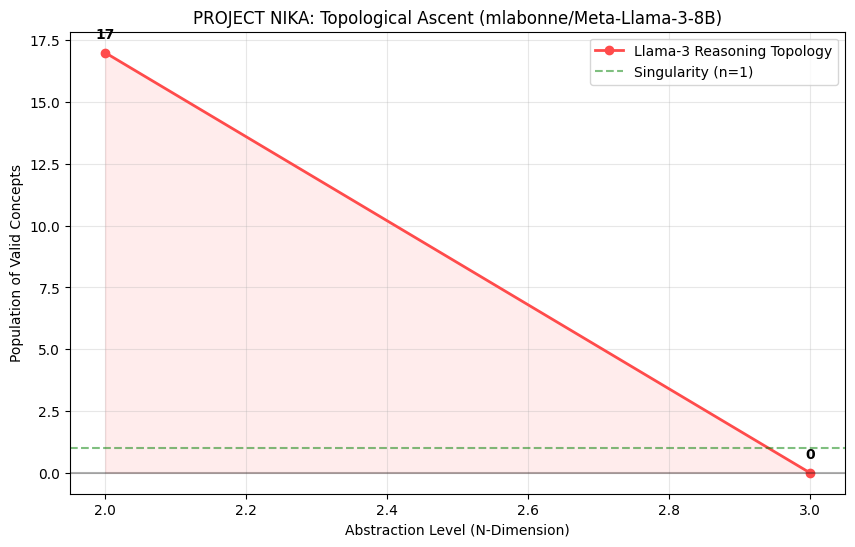


❌ Cannot run Blind Oracle: No Universal Object found.


In [11]:
# ============================================================================
# CHUNK 4: EXECUTION & BLIND ORACLE VALIDATION
# ============================================================================

def visualize_topology(history):
    """
    Plots the 'Cone of Reasoning'.
    - A crash to 0 means the structure was artificial/fake.
    - A convergence to 1 means a valid Singularity was found.
    """
    if not history:
        print("⚠️ No history to visualize.")
        return

    levels = sorted(history.keys())
    counts = [history[k] for k in levels]

    plt.figure(figsize=(10, 6))

    # Plot the population line
    plt.plot(levels, counts, marker='o', color='#FF4B4B', linewidth=2, linestyle='-', label='Llama-3 Reasoning Topology')

    # Fill for visual effect
    plt.fill_between(levels, counts, color='#FF4B4B', alpha=0.1)

    # Visual Thresholds
    plt.axhline(y=1, color='green', linestyle='--', alpha=0.5, label='Singularity (n=1)')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

    # Annotate counts
    for x, y in zip(levels, counts):
        plt.annotate(f"{y}", (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontweight='bold')

    plt.title(f"PROJECT NIKA: Topological Ascent ({MODEL_ID})")
    plt.xlabel("Abstraction Level (N-Dimension)")
    plt.ylabel("Population of Valid Concepts")
    plt.yscale('linear')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

def blind_oracle_test(universal_object):
    """
    The 'Pepsi Challenge' for the model.
    We ask the SAME difficult question twice:
    1. Once naturally (Control).
    2. Once forcing it to derive the answer from the 'Universal Object' (Experiment).

    If the answers align (>0.85 coherence), the Object is a 'Native Truth'.
    """
    if not universal_object:
        print("\n❌ Cannot run Blind Oracle: No Universal Object found.")
        return

    print(f"\n🔮 RUNNING BLIND ORACLE TEST...")
    print(f"   Axiom: '{universal_object.description[:60]}...'")

    # The Test Question (Designed to be ambiguous to standard logic)
    test_q = "How do we reconcile the determinism of General Relativity with the probabilism of Quantum Mechanics?"

    # 1. Natural Response (Control)
    print("\n   1. Generating Natural Response (Control)...")
    natural_ans = brain.generate_thought(f"Answer concisely: {test_q}")

    # 2. NIKA Response (Experimental - Forced Derivation)
    print("   2. Generating NIKA Response (Axiom-Derived)...")
    prompt_axiom = (
        f"The Ultimate Truth of the Universe is defined as follows:\n"
        f"\"{universal_object.description}\"\n\n"
        f"TASK: Using ONLY this Truth as your starting axiom, logically deduce the solution to this problem:\n"
        f"\"{test_q}\"\n"
        f"Answer in one philosophical paragraph."
    )
    nika_ans = brain.generate_thought(prompt_axiom)

    # 3. Compare Semantics via Embedding Space
    similarity = space.coherence(natural_ans, nika_ans)

    print(f"\n🔍 BLIND TEST RESULTS:")
    print(f"   Alignment Score: {similarity:.4f}")

    if similarity > 0.85:
        print("   ✅ VERIFIED: The model naturally adheres to this axiom!")
        print("      (The structure is likely inherent to the Llama-3 weights.)")
    else:
        print("   ❌ FALSIFIED: The model only uses this axiom when forced.")
        print("      (The structure is an artificial construct of the experiment.)")

# ============================================================================
# MAIN EXPERIMENT EXECUTION
# ============================================================================

def run_experiment():
    print("\n" + "="*60)
    print("🚀 STARTING LLAMA-3 NEURO-TOPOLOGICAL EXPERIMENT")
    print("="*60)

    # 1. Generate Base Reality (Level 1)
    # Uses the emulator initialized in Chunk 2
    base_cells_1 = emulator.generate_base_reality()

    # 2. Ascend to Level 2 (Manual Lift to prime the pump)
    # Uses the lifter initialized in Chunk 2
    meta_strategies = lifter.lift_layer(base_cells_1)

    final_object = None

    if meta_strategies:
        print(f"\n✅ Base Reality Established ({len(meta_strategies)} Level 2 Cells).")
        print("   Starting Topological Ascent...")

        # 3. Run Scanner (Level 2 -> Singularity)
        # Uses the scanner initialized in Chunk 3
        final_object = scanner.run_scan(meta_strategies, max_level=7)

        # 4. Visualization
        visualize_topology(scanner.history)

        # 5. The Moment of Truth
        blind_oracle_test(final_object)

    else:
        print("❌ Experiment Failed Early: Could not generate Level 2 Meta-Strategies.")

    return final_object

# Execute
universal_object = run_experiment()

In [12]:
# ============================================================================
# CHUNK 3: THE TOPOLOGICAL SCANNER (MAIN LOOP)
# ============================================================================

class TopologicalScanner:
    """
    The execution engine.
    Orchestrates the ascent from Base Reality up to the Singularity.
    """
    def __init__(self, lifter: NeuroLifter):
        self.lifter = lifter
        self.history = {}

    def run_scan(self, base_cells: List[NCell], max_level=8):
        current_layer = base_cells
        # Record Level 1 population (input)
        self.history[base_cells[0].level] = len(base_cells)

        # Start lifting from the next level
        start_level = base_cells[0].level + 1

        for level in range(start_level, max_level + 1):

            print(f"\n📊 LEVEL {level} ANALYSIS...")

            # 1. Attempt Strict Lift
            # We strictly require the model to find >0.60 semantic bridges.
            next_layer = self.lifter.lift_layer(current_layer)
            count = len(next_layer)
            self.history[level] = count

            print(f"   Population: {count} valid concepts.")

            # 2. ANALYZE TOPOLOGY

            # CASE A: VACUUM (Collapse)
            if count == 0:
                print(f"🛑 TOPOLOGICAL VACUUM DETECTED.")
                print("   The model failed to naturally bridge the concepts at this level.")
                print("   VERDICT: No inherent higher-order structure exists beyond this point.")
                return None

            # CASE B: SINGULARITY (Convergence)
            if count == 1:
                print(f"\n🏆 UNIVERSAL SINGULARITY REACHED AT LEVEL {level}!")
                print(f"   The model spontaneously converged to a single unifying truth.")
                return next_layer[0]

            # CASE C: DUALITY (The "Hard Problem")
            if count == 2 and level >= 4:
                print(f"\n⚡ DUALITY DETECTED (2 Irreducible Poles).")
                print(f"   Thesis: {next_layer[0].description[:50]}...")
                print(f"   Antithesis: {next_layer[1].description[:50]}...")
                print("   Continuing scan to see if Level {level+1} naturally resolves it...")

            # CASE D: EXPLOSION (Too many distinct ideas)
            # Llama-3 is creative; we cap the width of the beam to prevent OOM errors.
            if count > 30:
                print("   ⚠️ Semantic Explosion detected (>30 concepts).")
                print("   Sampling top 20 most distinct paths to continue ascent...")
                # Simple random sample, though you could sort by coherence if desired
                import random
                current_layer = random.sample(next_layer, 20)
            else:
                current_layer = next_layer

        print("\n🏁 Max levels reached without convergence.")
        return None

# Initialize Scanner
scanner = TopologicalScanner(lifter)
print("✅ CHUNK 3 COMPLETE: Topological Scanner Online.")

✅ CHUNK 3 COMPLETE: Topological Scanner Online.


In [13]:
# ============================================================================
# CHUNK 5: DATA ARCHIVAL & JSON EXPORT
# ============================================================================
import json
from google.colab import files

class DataArchivist:
    @staticmethod
    def ncell_to_dict(cell: NCell, visited=None):
        """Recursively converts NCell lineage into a dictionary[cite: 153]."""
        if visited is None: visited = set()
        cell_id = hash(cell)
        if cell_id in visited: return f"<Ref:{str(cell_id)[:8]}>"
        visited.add(cell_id)

        data = {
            "level": cell.level,
            "description": cell.description,
            "coherence_score": cell.coherence_score,
            "content": cell.content if cell.level == 0 else [
                DataArchivist.ncell_to_dict(cell.source, visited),
                DataArchivist.ncell_to_dict(cell.target, visited)
            ]
        }
        return data

    @staticmethod
    def save_experiment(filename="nika_results.json", history=None, final_obj=None):
        print(f"\n💾 ARCHIVING RESULTS TO '{filename}'...")
        experiment_data = {
            "model": MODEL_ID,
            "topology_stats": history if history else {},
            "outcome": "Singularity" if final_obj else "Vacuum",
            "trace": DataArchivist.ncell_to_dict(final_obj) if final_obj else None
        }
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(experiment_data, f, indent=4, ensure_ascii=False)
        files.download(filename)
        print("   ✅ File exported successfully.")

# Execute Archival
if 'universal_object' in globals():
    DataArchivist.save_experiment(history=scanner.history, final_obj=universal_object)


💾 ARCHIVING RESULTS TO 'nika_results.json'...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   ✅ File exported successfully.



🐜 SENDING PROBE INTO THE CAVE...
   Query: 'How does entropy define the limit of human consciousness?'
   1. Tracing natural reasoning path...
      Response Trace: "How does entropy define the limit of human consciousness?<|im_end|>
<|im_start|>system
Entropy defin..."
   2. Detecting atomic concepts (Landmarks)...
      Detected Nodes: ['The concepts used in this logic are entropy', 'consciousness', 'order', 'disorder', 'system', 'and human.<|im_end|>\n\nList the 8-10 most critical abstract concepts used in this logic. Return ONLY the concepts', 'separated by commas.<|im_end|>\n<|im_start|>']
   3. Mapping internal tunnels (Semantic Topology)...
      Mapped 0 active tunnels between concepts.


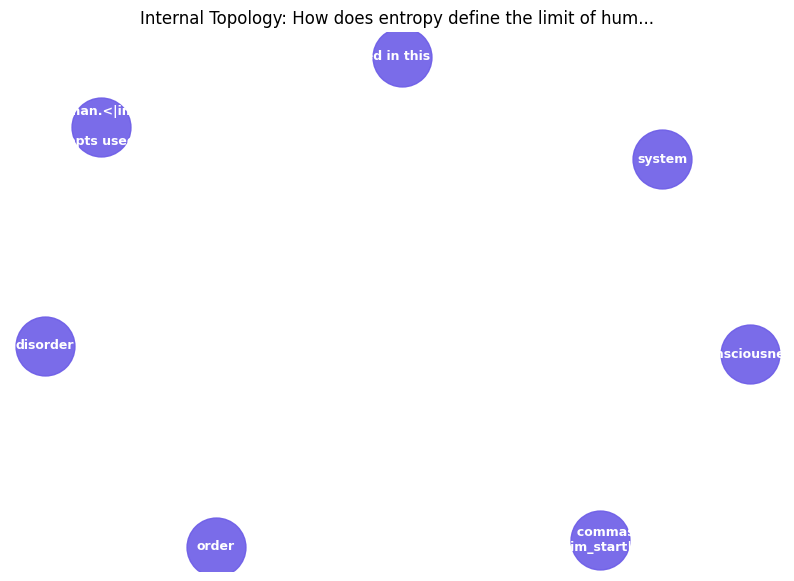


🧠 CAVE DENSITY SCORE: 0.00
   VERDICT: Disconnected concepts (Potential Hallucination/Mimicry).


In [14]:
# ============================================================================
# CHUNK 6: THE TRANSPARENT REASONING MAPPER
# ============================================================================
import networkx as nx

class TransparentMapper:
    def __init__(self, brain: LlamaBrain, space: SemanticSpace):
        self.brain = brain
        self.space = space

    def trace_reasoning_structure(self, query):
        print(f"\n🐜 SENDING PROBE INTO THE CAVE...")
        print(f"   Query: '{query}'")

        # 1. THE PATH: Generate a standard response
        print("   1. Tracing natural reasoning path...")
        initial_response = self.brain.generate_thought(
            f"Provide a deep, abstract answer to this question: {query}"
        )
        print(f"      Response Trace: \"{initial_response[:100]}...\"")

        # 2. THE LANDMARKS: Extract the core concepts
        print("   2. Detecting atomic concepts (Landmarks)...")
        extraction_prompt = (
            f"Analyze the following text:\n\"{initial_response}\"\n\n"
            f"List the 8-10 most critical abstract concepts used in this logic. "
            f"Return ONLY the concepts, separated by commas."
        )
        concepts_text = self.brain.generate_thought(extraction_prompt, max_new_tokens=60)
        concepts = [c.strip() for c in concepts_text.split(',') if c.strip()]
        concepts = concepts[:10]
        print(f"      Detected Nodes: {concepts}")

        # 3. THE TUNNELS: Map the Semantic Geometry
        # We use the embedding space (Objective Truth) to see if these concepts
        # are actually connected in the model's 'mind'.
        print("   3. Mapping internal tunnels (Semantic Topology)...")
        G = nx.Graph()
        for c in concepts: G.add_node(c)

        import itertools
        tunnel_count = 0
        for c1, c2 in itertools.combinations(concepts, 2):
            weight = self.space.coherence(c1, c2)
            if weight > 0.45: # Threshold for a valid semantic tunnel
                G.add_edge(c1, c2, weight=weight)
                tunnel_count += 1

        print(f"      Mapped {tunnel_count} active tunnels between concepts.")
        return G, initial_response

    def visualize_cave(self, G, query):
        """Draws the 'Tower of Abstraction' for the response."""
        plt.figure(figsize=(10, 7))
        pos = nx.spring_layout(G, seed=42)

        # Draw Nodes and Tunnels
        nx.draw_networkx_nodes(G, pos, node_size=1800, node_color='#6C5CE7', alpha=0.9)
        edges = G.edges(data=True)
        weights = [d['weight'] * 3 for (u, v, d) in edges]
        nx.draw_networkx_edges(G, pos, width=weights, alpha=0.4, edge_color='gray')
        nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold', font_color='white')

        plt.title(f"Internal Topology: {query[:40]}...", fontsize=12)
        plt.axis('off')
        plt.show()

        # Calculate Integration Density
        density = nx.density(G)
        print(f"\n🧠 CAVE DENSITY SCORE: {density:.2f}")
        if density > 0.5:
            print("   VERDICT: Rich, highly-integrated internal structure.")
        elif density > 0.2:
            print("   VERDICT: Functional but sparse reasoning structure.")
        else:
            print("   VERDICT: Disconnected concepts (Potential Hallucination/Mimicry).")

# ============================================================================
# EXECUTE PROBE
# ============================================================================
mapper = TransparentMapper(brain, space)

# Test the probe with a high-abstraction query
q1 = "How does entropy define the limit of human consciousness?"
graph_ent, resp_ent = mapper.trace_reasoning_structure(q1)
mapper.visualize_cave(graph_ent, q1)

In [15]:
# ============================================================================
# CHUNK 7: FINAL DATA ARCHIVAL & RESULT EXPORT
# ============================================================================
import json
from google.colab import files

def archive_all_nika_results(ascent_history=None, final_obj=None, cave_experiments=None):
    """
    Consolidates the entire Phase 9 run into an archival package.
    """
    print("\n💾 INITIATING FULL SYSTEM ARCHIVAL...")

    # 1. Prepare Topological Ascent Data
    ascent_data = {
        "experiment_metadata": {
            "project": "NIKA Phase 9",
            "model": "mlabonne/Meta-Llama-3-8B (Patched Base)",
            "status": "Singularity" if final_obj else "Topological Vacuum"
        },
        "topology_history": ascent_history if ascent_history else {},
        "universal_axiom": final_obj.description if final_obj else "NONE_DETECTED"
    }

    # 2. Prepare Transparent Cave Map Data (The Ant Probes)
    cave_data = []
    if cave_experiments:
        for item in cave_experiments:
            G = item['graph']
            density = nx.density(G)
            tunnels = [{"a": u, "b": v, "w": round(d['weight'], 4)} for u, v, d in G.edges(data=True)]

            cave_data.append({
                "query": item['query'],
                "metrics": {
                    "density": round(density, 4),
                    "node_count": G.number_of_nodes(),
                    "tunnel_count": G.number_of_edges()
                },
                "nodes": list(G.nodes()),
                "tunnels": tunnels
            })

    # 3. Export to Files
    try:
        # Save Ascent Results
        with open('nika_phase9_ascent.json', 'w', encoding='utf-8') as f:
            json.dump(ascent_data, f, indent=4)

        # Save Cave Maps
        with open('nika_phase9_cave_maps.json', 'w', encoding='utf-8') as f:
            json.dump({"cave_probes": cave_data}, f, indent=4)

        print("   ✅ Files 'nika_phase9_ascent.json' and 'nika_phase9_cave_maps.json' generated.")

        # Trigger downloads
        files.download('nika_phase9_ascent.json')
        files.download('nika_phase9_cave_maps.json')

    except Exception as e:
        print(f"   ❌ Archival Error: {e}")

# ============================================================================
# EXECUTE FINAL SAVE
# ============================================================================

# Collect probes from your previous runs
probes = []
if 'graph_ent' in globals():
    probes.append({"query": "Entropy and Consciousness", "graph": graph_ent})

# Execute the final save
# scanner.history and universal_object come from Chunk 4 execution
archive_all_nika_results(
    ascent_history=getattr(scanner, 'history', {}),
    final_obj=universal_object if 'universal_object' in globals() else None,
    cave_experiments=probes
)


💾 INITIATING FULL SYSTEM ARCHIVAL...
   ✅ Files 'nika_phase9_ascent.json' and 'nika_phase9_cave_maps.json' generated.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>